# PostHoc Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_csv('../Data Source/final_data_with_structural_predictions.csv')

target = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
features = [
    'structural_internet_adoption', #Structural Determinants of Health - predicted values for broadband internet adoption
    'pct_hlth_unins', #Material Circumstances | Healthcare
    'brfss_checkup_ageadjprv', # Behaviors and Biological Factors
    'brfss_csmoking_ageadjprv', # Behaviors and Biological Factors
    #'brfss_depression_ageadjprv', #Psychological Factors
    #'brfss_ghlth_ageadjprv', #Impact on Well-being - commented out due to correlation with DV
    'brfss_mhlth_ageadjprv', #Psychological Factors
    'brfss_obesity_ageadjprv', #Behaviors and Biological Factors
    'pct_age_gte65', # Biological Factors | Age
    #'pct_tp_veh_0', #Material Circumstances | Transportation Commented out for reference comparison
    'pct_tp_veh_1', #Material Circumstances | Transportation
    'pct_tp_veh_2', #Material Circumstances | Transportation
    'pct_tp_veh_3', #Material Circumstances | Transportation

]
geo = [
    'state',
    'county'
]
df = df[geo + target + features]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   state                         3076 non-null   object 
 1   county                        3076 non-null   object 
 2   brfss_diabetes_ageadjprv      3076 non-null   float64
 3   structural_internet_adoption  3076 non-null   float64
 4   pct_hlth_unins                3076 non-null   float64
 5   brfss_checkup_ageadjprv       3076 non-null   float64
 6   brfss_csmoking_ageadjprv      3076 non-null   float64
 7   brfss_mhlth_ageadjprv         3076 non-null   float64
 8   brfss_obesity_ageadjprv       3076 non-null   float64
 9   pct_age_gte65                 3076 non-null   float64
 10  pct_tp_veh_1                  3076 non-null   float64
 11  pct_tp_veh_2                  3076 non-null   float64
 12  pct_tp_veh_3                  3076 non-null   float64
dtypes: 

# Predictive Power

In [3]:
X = df[features]
y = df[target]
y = np.array(y).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=418)

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
print('Linear Regression')
print('Size of training set: ', X_train.shape[0])
print('Size of testing set: ', X_test.shape[0])

# Assess MAE, MSE, RMSE, and R^2 with cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=418)

print('')
mae = cross_val_score(lr, X_train, y_train, scoring=make_scorer(mean_absolute_error), cv=cv, n_jobs=-1)
print('MAE: %.3f (%.3f)' % (np.mean(mae), np.std(mae)))
mse = cross_val_score(lr, X_train, y_train, scoring=make_scorer(mean_squared_error), cv=cv, n_jobs=-1)
print('MSE: %.3f (%.3f)' % (np.mean(mse), np.std(mse)))
rmse = cross_val_score(lr, X_train, y_train, scoring=make_scorer(mean_squared_error, squared=False), cv=cv, n_jobs=-1)
print('RMSE: %.3f (%.3f)' % (np.mean(rmse), np.std(rmse)))
r2 = cross_val_score(lr, X_train, y_train, scoring=make_scorer(r2_score), cv=cv, n_jobs=-1)
print('R^2: %.3f (%.3f)' % (np.mean(r2), np.std(r2)))

# Assess MAE, MSE, RMSE, and R^2 with test set
y_pred = lr.predict(X_test)
print('')
print('Test set')
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)
mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % rmse)
r2 = r2_score(y_test, y_pred)
print('R^2: %.3f' % r2)


Linear Regression
Size of training set:  2307
Size of testing set:  769

MAE: 0.695 (0.042)
MSE: 0.872 (0.128)
RMSE: 0.931 (0.069)
R^2: 0.828 (0.026)

Test set
MAE: 0.722
MSE: 0.899
RMSE: 0.948
R^2: 0.817


c:\Users\mfarm\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Geographic Analysis
Organized by larger regions defined by the US Census Bureau. The regions are Northeast, Midwest, South, and West.

In [4]:
regions = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania'],
    'Midwest': ['Indiana', 'Illinois', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
    'South': ['Delaware', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
}

df['region'] = df['state'].apply(lambda x: [k for k, v in regions.items() if x in v][0])

unmapped = df[~df['region'].isin(regions.keys())]
unmapped['state'].unique()

array([], dtype=object)

In [5]:
def regression_by_region(region_name, data, predictors, target):
    region_data = data[data['region'] == region_name]
    region_target = region_data[target]
    region_features = region_data[predictors]
    region_features = sm.add_constant(region_features)
    region_model = sm.OLS(region_target, region_features).fit()
    bb_int_coef = region_model.params['structural_internet_adoption']

    return region_model, bb_int_coef

region_coef = {}

for region in df['region'].unique():
    region_model, bb_int_coef = regression_by_region(region, df, features, target)
    region_coef[region] = bb_int_coef

region_coef

{'West': -0.15729133014029578,
 'South': -0.1702666732733612,
 'Northeast': -0.12276492351804041,
 'Midwest': -0.034782816738106126}

In [6]:
def regression_by_state(state_name, data, predictors, target):
    state_data = data[data['state'] == state_name]
    state_target = state_data[target]
    state_features = state_data[predictors]
    state_features = sm.add_constant(state_features)
    state_model = sm.OLS(state_target, state_features).fit()
    bb_int_coef = state_model.params['structural_internet_adoption']

    return state_model, bb_int_coef

state_coef = {}

for state in df['state'].unique():
    state_model, bb_int_coef = regression_by_state(state, df, features, target)
    state_coef[state] = bb_int_coef

state_coef


{'Alaska': -0.05884673128919905,
 'Alabama': -0.12831842782698488,
 'Arkansas': -0.11260446423719674,
 'Arizona': -0.1745432807528502,
 'California': -0.27852504887491714,
 'Colorado': -0.10424793004159255,
 'Connecticut': -0.19505437354272925,
 'District of Columbia': 0.04599889588834895,
 'Delaware': 0.03527158155166698,
 'Georgia': -0.07295406371334967,
 'Hawaii': -0.002595910532552597,
 'Iowa': -0.09822580743794274,
 'Idaho': -0.048920537652035856,
 'Illinois': -0.11358279191783988,
 'Indiana': -0.0569649874445968,
 'Kansas': -0.10693571872043778,
 'Kentucky': -0.005176202255726181,
 'Louisiana': 0.000835461607604171,
 'Massachusetts': 0.0702467969937296,
 'Maryland': -0.06707319337439377,
 'Maine': -0.1634605894224428,
 'Michigan': -0.06790241946241773,
 'Minnesota': -0.06835919132574901,
 'Missouri': -0.03631935398288161,
 'Mississippi': -0.03536786060421529,
 'Montana': 0.0002252542713251371,
 'North Carolina': -0.095108623458034,
 'North Dakota': -0.0129962990844126,
 'Nebraska

# Machine Learning : Alternative Models

In [7]:
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Multi-Layer Perceptron': MLPRegressor()
}


dt_params = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10]
}

rf_params = {
    'n_estimators': [50, 150],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 6, 10]
}

gb_params = {
    'n_estimators': [50, 150],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 6, 10],
    'learning_rate': [0.01, 0.1]
}

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

mlp_params = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive']
}

params = {
    'Decision Tree': dt_params,
    'Random Forest': rf_params,
    'Gradient Boosting': gb_params,
    'K-Nearest Neighbors': knn_params,
    'Multi-Layer Perceptron': mlp_params
}


In [8]:
for model_name, model in models.items():
    print('Model:', model_name)
    grid_search = GridSearchCV(model, params[model_name], cv=15, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
    grid_search.fit(X, y)
    print('Best Parameters:', grid_search.best_params_)
    print('Best Score:', -grid_search.best_score_)
    print()

Model: Decision Tree
Fitting 15 folds for each of 810 candidates, totalling 12150 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 7}
Best Score: 0.8773217728609428

Model: Random Forest
Fitting 15 folds for each of 72 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Score: 0.6851563911498342

Model: Gradient Boosting
Fitting 15 folds for each of 144 candidates, totalling 2160 fits


c:\Users\mfarm\miniconda3\envs\nlp\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.6712469080269428

Model: K-Nearest Neighbors
Fitting 15 folds for each of 12 candidates, totalling 180 fits
Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Score: 0.718627220833618

Model: Multi-Layer Perceptron
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score: 0.7027604103494559



Model: Decision Tree
Fitting 15 folds for each of 810 candidates, totalling 12150 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 3}
Best Score: 0.8671893721971518

Model: Random Forest
Fitting 15 folds for each of 72 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Score: 0.6849797287795085

Model: Gradient Boosting
Fitting 15 folds for each of 144 candidates, totalling 2160 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150}
Best Score: 0.6625742713024878

Model: K-Nearest Neighbors
Fitting 15 folds for each of 12 candidates, totalling 180 fits
Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Score: 0.703288979055978

Model: Multi-Layer Perceptron
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score: 0.6786420125378039

In [9]:
from sklearn.model_selection import RandomizedSearchCV

for model_name, model in models.items():
    print('Model:', model_name)
    random_search = RandomizedSearchCV(model, params[model_name], cv=15, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
    random_search.fit(X, y)
    print('Best Parameters:', random_search.best_params_)
    print('Best Score:', -random_search.best_score_)
    print()

Model: Decision Tree
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'min_samples_split': 9, 'min_samples_leaf': 7, 'max_depth': 9}
Best Score: 0.8871685724003784

Model: Random Forest
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}
Best Score: 0.6893219681012521

Model: Gradient Boosting
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}
Best Score: 0.6730871325765899

Model: K-Nearest Neighbors
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7}
Best Score: 0.718627220833618

Model: Multi-Layer Perceptron
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'solver': 'adam', 'learning_rate': 'adapt

c:\Users\mfarm\miniconda3\envs\nlp\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: Decision Tree
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'min_samples_split': 8, 'min_samples_leaf': 10, 'max_depth': 9}
Best Score: 0.8723100231790681

Model: Random Forest
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best Score: 0.6883450093905926

Model: Gradient Boosting
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 5, 'learning_rate': 0.1}
Best Score: 0.6663109565673868

Model: K-Nearest Neighbors
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7}
Best Score: 0.703288979055978

Model: Multi-Layer Perceptron
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'activation': 'relu'}
Best Score: 0.6909386754237425

In [10]:
best_fit_params_gb = {
    'n_estimators': 150,
    'min_samples_split': 10,
    'min_samples_leaf': 6,
    'max_depth': 5,
    'learning_rate': 0.1
}

model = GradientBoostingRegressor(**best_fit_params_gb)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=418)
cv_r2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
cv_rmse = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
cv_mae = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

print('Gradient Boosting')
print('R^2: %.3f (%.3f)' % (np.mean(cv_r2), np.std(cv_r2)))
print('RMSE: %.3f (%.3f)' % (np.mean(-cv_rmse), np.std(cv_rmse)))
print('MAE: %.3f (%.3f)' % (np.mean(-cv_mae), np.std(cv_mae)))
      



Gradient Boosting
R^2: 0.887 (0.014)
RMSE: 0.755 (0.046)
MAE: 0.561 (0.028)


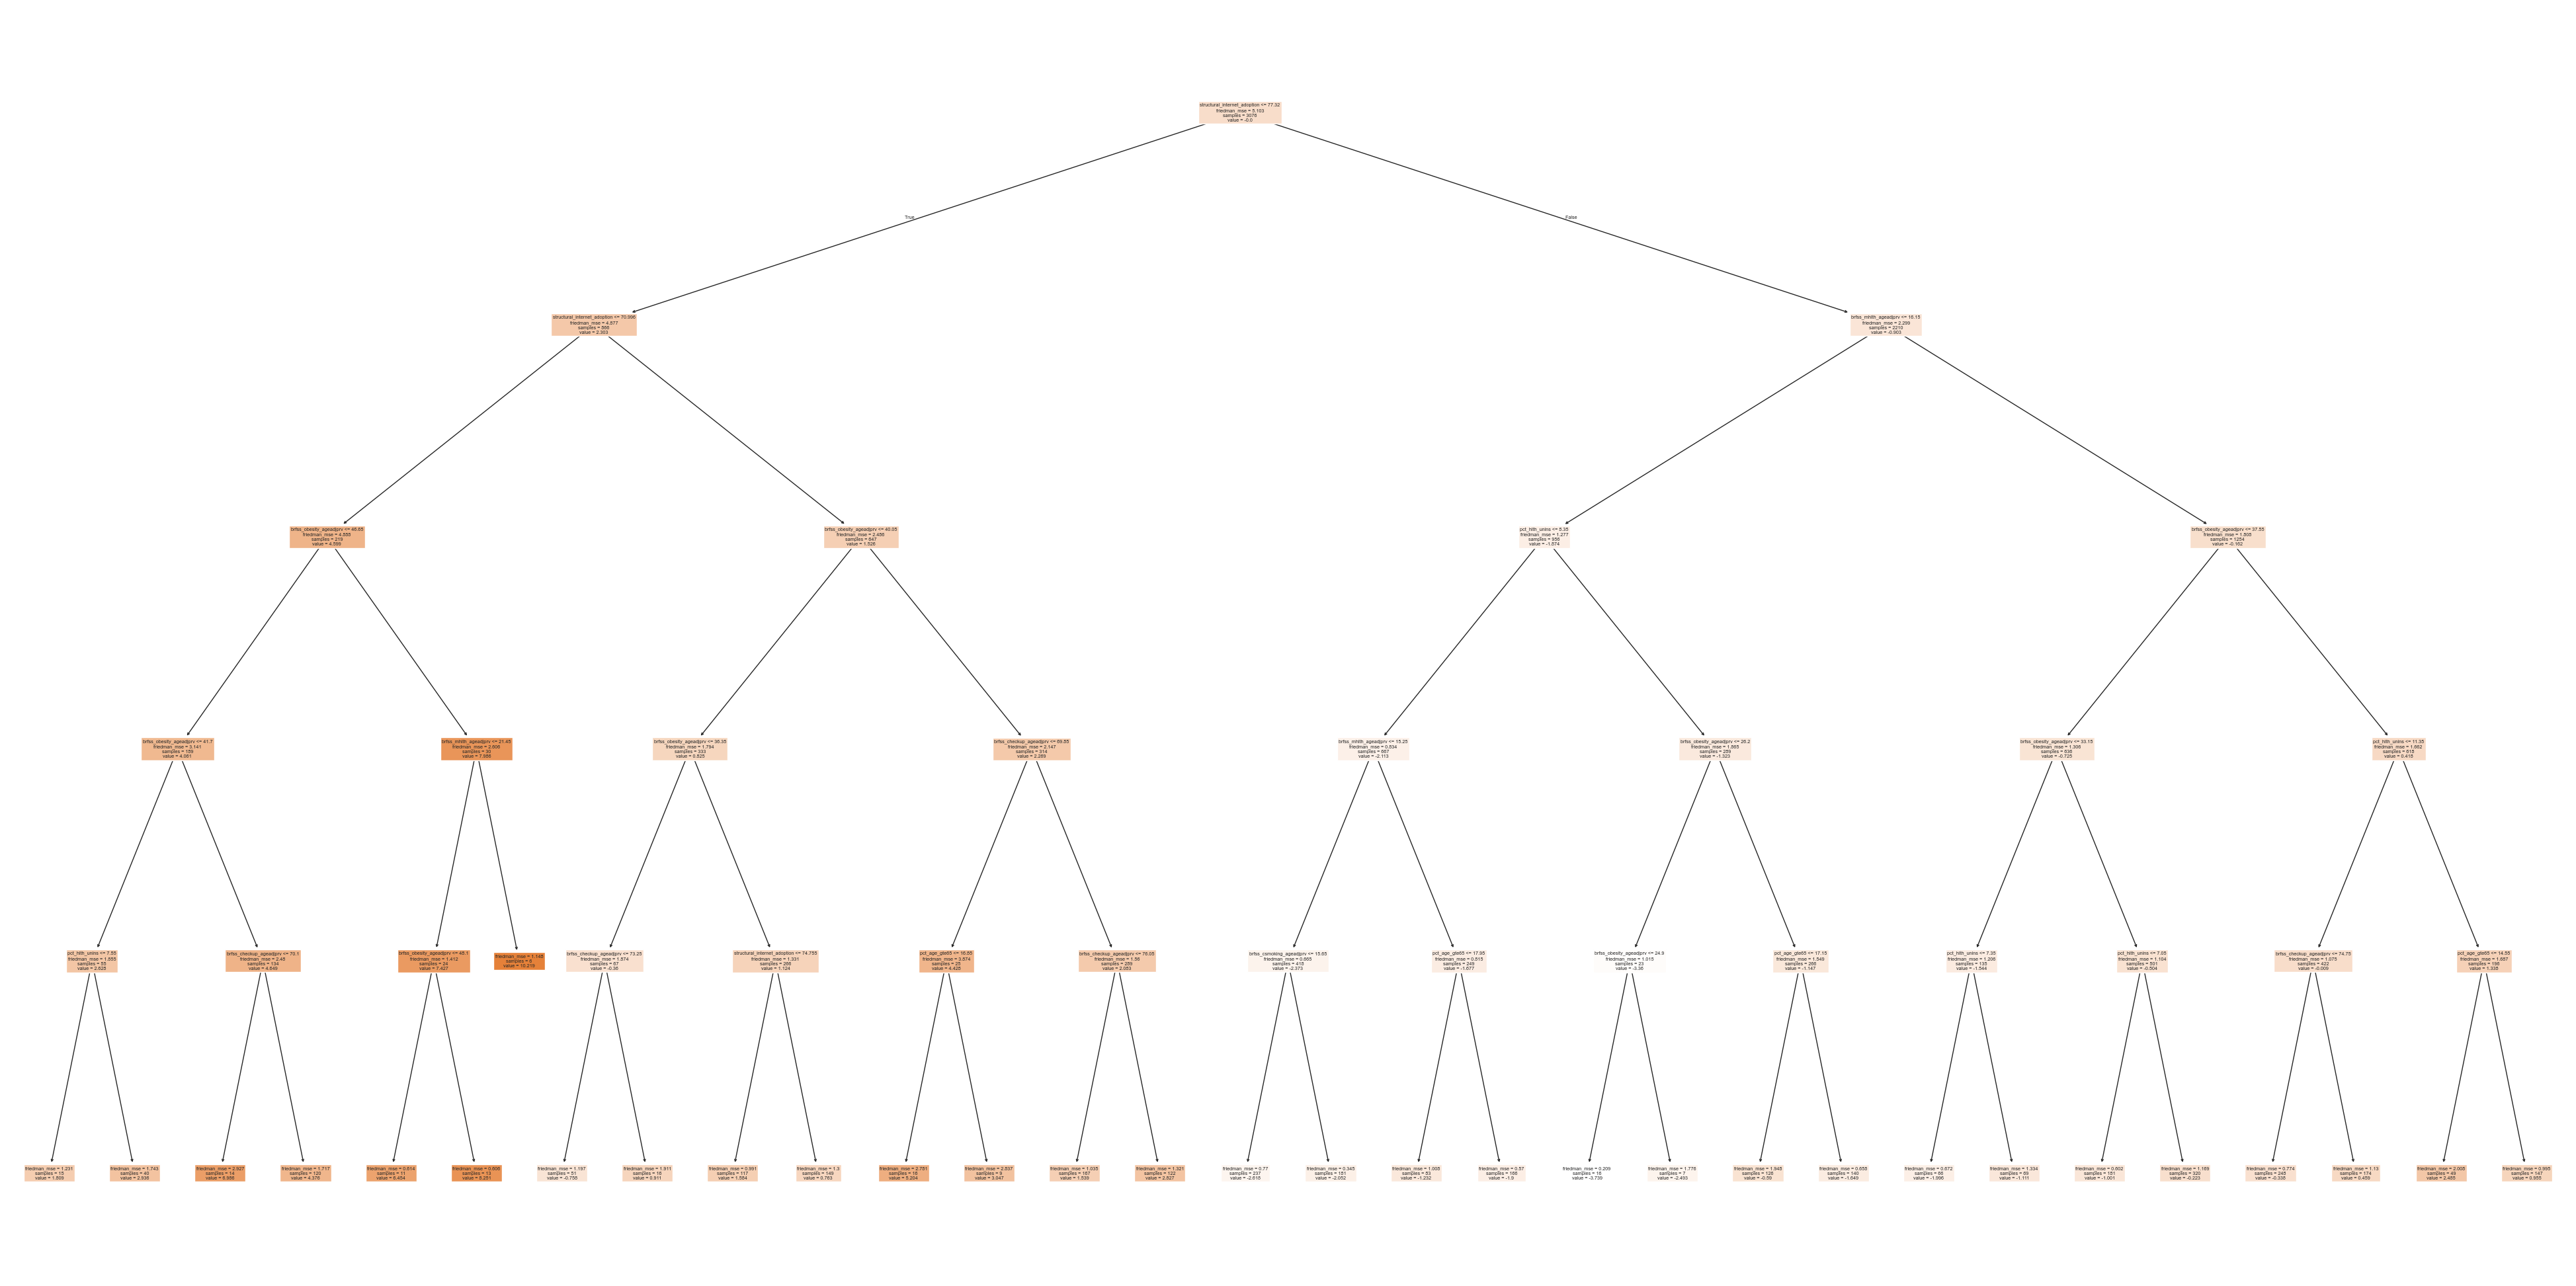

In [11]:
#create a visualization of the gb tree
model.fit(X, y)
plt.figure(figsize=(50, 25))
plot_tree(model.estimators_[0][0], feature_names=features, filled=True)
plt.show()


C:\Users\mfarm\AppData\Local\Temp\ipykernel_36328\2334866519.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])


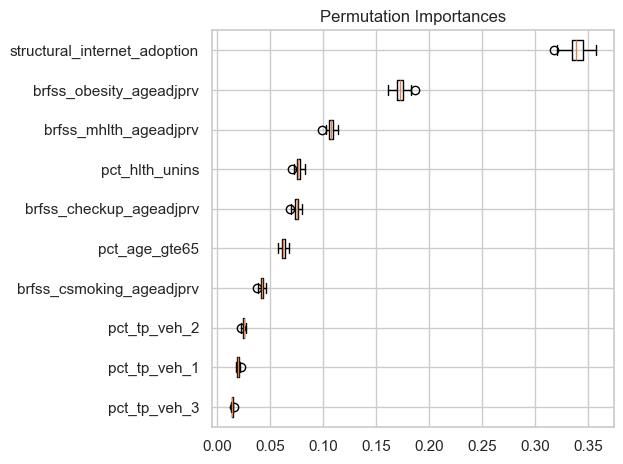

In [12]:
model.fit(X, y)
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X, y, n_repeats=100, random_state=42, n_jobs=-1)
sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()


In [15]:
X

,structural_internet_adoption,pct_hlth_unins,brfss_checkup_ageadjprv,brfss_csmoking_ageadjprv,brfss_mhlth_ageadjprv,brfss_obesity_ageadjprv,pct_age_gte65,pct_tp_veh_1,pct_tp_veh_2,pct_tp_veh_3
0,71.559583,40.0,60.7,18.6,12.9,31.3,11.7,37.2,28.0,10.8
1,81.190775,19.6,61.6,15.5,12.2,30.3,7.0,39.8,35.5,10.5
2,90.539732,10.5,62.9,14.9,14.5,32.9,11.5,32.9,39.8,21.8
3,59.923557,15.1,62.6,35.4,21.4,43.1,7.5,23.9,11.6,4.4
4,77.196419,17.0,61.4,18.7,15.4,35.6,13.1,39.4,24.8,26.0
...,...,...,...,...,...,...,...,...,...,...
3071,84.915533,13.3,69.9,17.8,16.1,34.3,12.7,21.6,37.8,38.5
3072,92.257869,11.1,66.1,11.1,12.7,21.7,15.5,30.0,43.1,24.3
3073,84.977307,11.2,63.5,16.8,15.7,33.3,14.7,24.0,30.3,42.1
3074,86.615208,10.7,62.7,16.4,15.3,33.6,22.3,25.0,38.4,32.7


In [16]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(X):
    # Rename column 'structural_internet_adoption' to 'Internet Adoption'
    X = X.rename(columns={'structural_internet_adoption': 'Internet Adoption'})
    # Rename column 'pct_hlth_unins' to 'Uninsured'
    X = X.rename(columns={'pct_hlth_unins': 'Uninsured'})
    # Rename column 'brfss_checkup_ageadjprv' to 'Annual Visit with PCP'
    X = X.rename(columns={'brfss_checkup_ageadjprv': 'Annual Visit with PCP'})
    # Rename column 'brfss_csmoking_ageadjprv' to 'Age-Adjusted Smoking Prevalence'
    X = X.rename(columns={'brfss_csmoking_ageadjprv': 'Age-Adjusted Smoking Prevalence'})
    # Rename column 'brfss_mhlth_ageadjprv' to 'Age-Adjusted Poor Mental Health'
    X = X.rename(columns={'brfss_mhlth_ageadjprv': 'Age-Adjusted Poor Mental Health'})
    # Rename column 'brfss_obesity_ageadjprv' to 'Age-Adjusted Obesity Prevalence'
    X = X.rename(columns={'brfss_obesity_ageadjprv': 'Age-Adjusted Obesity Prevalence'})
    # Rename column 'pct_age_gte65' to 'Age Greater than 65'
    X = X.rename(columns={'pct_age_gte65': 'Age Greater than 65'})
    # Rename column 'Age Greater than 65' to 'Age 65+'
    X = X.rename(columns={'Age Greater than 65': 'Age 65+'})
    # Rename column 'pct_tp_veh_1' to 'One Vehicle - Household'
    X = X.rename(columns={'pct_tp_veh_1': 'One Vehicle - Household'})
    # Rename column 'pct_tp_veh_2' to 'Two Vehicle - Household'
    X = X.rename(columns={'pct_tp_veh_2': 'Two Vehicle - Household'})
    # Rename column 'pct_tp_veh_3' to 'Three Vehicle - Household'
    X = X.rename(columns={'pct_tp_veh_3': 'Three Vehicle - Household'})
    return X

X_clean = clean_data(X.copy())
X_clean.head()

,Internet Adoption,Uninsured,Annual Visit with PCP,Age-Adjusted Smoking Prevalence,Age-Adjusted Poor Mental Health,Age-Adjusted Obesity Prevalence,Age 65+,One Vehicle - Household,Two Vehicle - Household,Three Vehicle - Household
0,71.559583,40.0,60.7,18.6,12.9,31.3,11.7,37.2,28.0,10.8
1,81.190775,19.6,61.6,15.5,12.2,30.3,7.0,39.8,35.5,10.5
2,90.539732,10.5,62.9,14.9,14.5,32.9,11.5,32.9,39.8,21.8
3,59.923557,15.1,62.6,35.4,21.4,43.1,7.5,23.9,11.6,4.4
4,77.196419,17.0,61.4,18.7,15.4,35.6,13.1,39.4,24.8,26.0


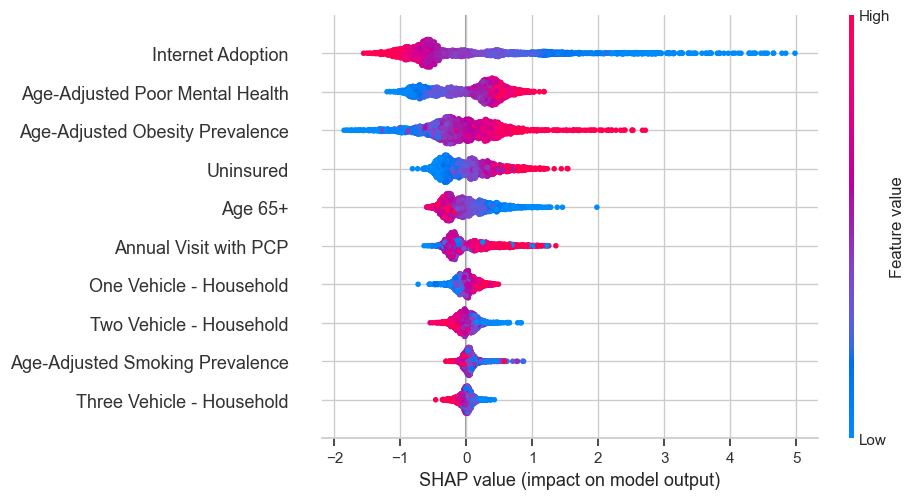

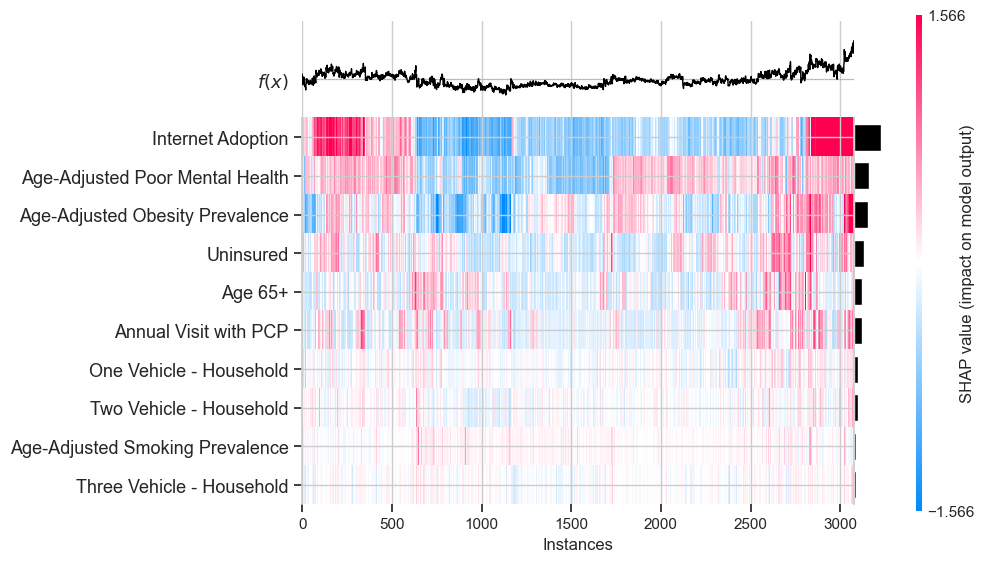

<Axes: xlabel='Instances'>

In [40]:
#SHAP values
import shap

shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer(X_clean, check_additivity=True)

shap.plots.beeswarm(shap_values, max_display=11)
shap.plots.heatmap(shap_values)

# shap.dependence_plot('structural_internet_adoption', shap_values.values, X, interaction_index='brfss_obesity_ageadjprv')
# shap.dependence_plot('structural_internet_adoption', shap_values.values, X, interaction_index='brfss_mhlth_ageadjprv')
# shap.dependence_plot('structural_internet_adoption', shap_values.values, X, interaction_index='brfss_csmoking_ageadjprv')
# shap.dependence_plot('structural_internet_adoption', shap_values.values, X, interaction_index='brfss_checkup_ageadjprv')
# shap.dependence_plot('structural_internet_adoption', shap_values.values, X, interaction_index='pct_hlth_unins')
# shap.dependence_plot('structural_internet_adoption', shap_values.values, X, interaction_index='pct_age_gte65')
# shap.dependence_plot('structural_internet_adoption', shap_values.values, X, interaction_index='pct_tp_veh_1')
# shap.dependence_plot('structural_internet_adoption', shap_values.values, X, interaction_index='pct_tp_veh_2')
# shap.dependence_plot('structural_internet_adoption', shap_values.values, X, interaction_index='pct_tp_veh_3')

# #waterfall plot
# shap.plots.waterfall(shap_values[0])

# OLS Predictive Capabilities and Cross-fold validation

In [5]:
#linear model
model = LinearRegression(fit_intercept=True)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
cv_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
cv_rmse = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
cv_abs_error = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

print('R2 Mean:', cv_r2.mean())
print('RMSE Mean:', -cv_rmse.mean())
print('MAE Mean:', -cv_abs_error.mean())


R2 Mean: 0.8267129089708214
RMSE Mean: 0.9349405717615872
MAE Mean: 0.7003232228946984
